In [1]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.special import comb as C
from scipy.stats import linregress
from statistics import median
from scipy.optimize import fminbound
import json

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )


In [3]:
def get_entropy_from_culling_factor_v2(c):
    S = od()
    sn = 0
#    for E in log_progress(c):
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
#        S[E] = np.log(c[E])
#        for E1 in c:
#            if (E1 > E):
#                S[E] += np.log(1 - c[E1])
    return S

def get_entropy_from_culling_factor_with_heat_v2(c):
    S = od()
    sn = 0
#    for E in log_progress(c):
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
#        if E in c:
#            S[E] = np.log(c[E])
#        for E1 in c:
#            if (E1 < E):
#                S[E] += np.log(1 - c[E1])
    return S

In [4]:
def read_files_v2(parameters):
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    D=parameters["D"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    heat=parameters["heat"];
    N = L * L;
    name = "./datasets/2DBlume{}_q{}_D{}_N{}_R{}_nSteps{}_run{}X.txt".format("Heating" * heat, q, "{0:07.6f}".format(D), N, R, nSteps, seed)
    print(name)
    culling_factor = od()
    print(N, R, nSteps, heat)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c
    parameters["culling_factor"] = culling_factor
    if not heat:
        parameters["S"] = get_entropy_from_culling_factor_v2(culling_factor)
    else:
        parameters["S"] = get_entropy_from_culling_factor_with_heat_v2(culling_factor)
    
    return parameters

def read_tuple_files(tpl):
    if tpl[1]["heat"]:
        return {
            "cool": read_files_v2(tpl[0]),
            "heat": read_files_v2(tpl[1])
        }

In [40]:
m_list = [10]
heat = [{
    "q": 3,
    "D": 1.95,
    "L": 32,
    "R" : 131072,
    "nSteps" : m,
    "seed" : 0,
    "heat": True
} for m in m_list]

parameters = []
for x in heat:
    parameters.append({
            "heat": read_files_v2(x)
        })

./datasets/2DBlumeHeating_q3_D1.950000_N1024_R131072_nSteps10_run0X.txt
1024 131072 10 True


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


In [25]:
def stitch_S(heat, cool):
    #not infinite values
    niv = sorted( list({E for E, S in heat["S"].items() if not np.isinf(S)} &
                       {E for E, S in cool["S"].items() if not np.isinf(S)}) )
    #chosen not infinite values
    cniv = niv[len(niv) // 3 : 2 * len(niv) // 3]
    #print(cniv)
    shift = 0
    count = 0
    for E in cniv:
        shift += heat["S"][E] - cool["S"][E]
        count += 1
    shift /= count

    result = od()
    for E in cool["S"]:
        if E < median(cniv):
            result[E] = cool["S"][E]
    for E in heat["S"]:
        if E >= median(cniv):
            result[E] = heat["S"][E] - shift    
    return {"S": result, "L": heat["L"], "D": heat["D"]}

In [26]:
for i, x in enumerate(parameters):
    parameters[i]["stitched"] = stitch_S(x["heat"], x["cool"])

KeyError: 'cool'

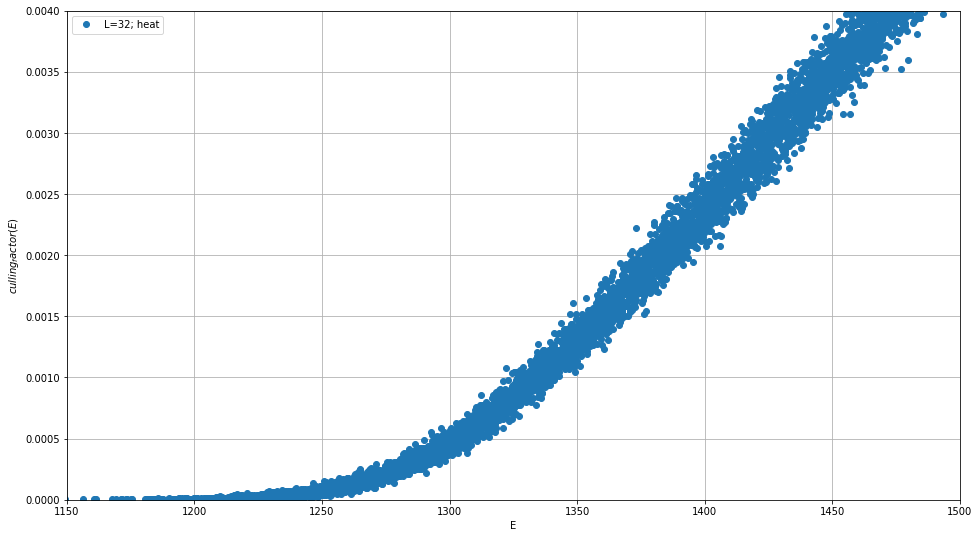

In [28]:
plt.figure(figsize=(16, 9))

i = 0
#heat, cool = parameters[i]["heat"], parameters[i]["cool"]
heat = parameters[i]["heat"]


plt.plot([E for E in heat["culling_factor"]], [S for E, S in heat["culling_factor"].items()]
         , 'o', label="L={}; heat".format(heat["L"]))

plt.ylabel("$culling_factor(E)$")
plt.xlabel("E")
#plt.ylim([-200, -175])
#plt.xlim([-216, -175])
plt.ylim([0.0, 0.004])
plt.xlim([1150, 1500])
plt.legend()
plt.grid()
#plt.savefig("./culling_factor_D{}_L{}.png".format(heat["D"], heat["L"]))

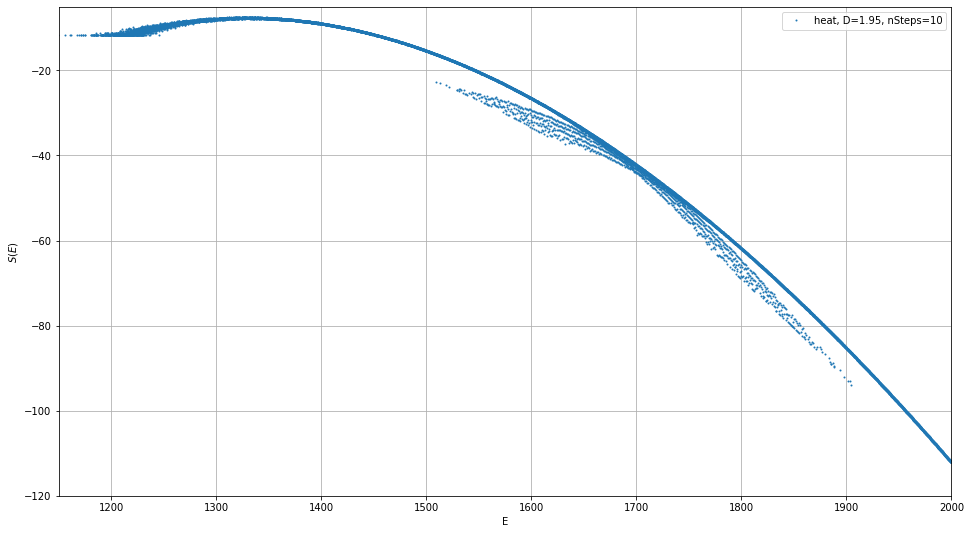

In [53]:
plt.figure(figsize=(16, 9))

for i in range(len(parameters))[0:1]:
    #heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    heat = parameters[i]["heat"]

    plt.plot([E for E in heat["S"]],
             [S for E, S in heat["S"].items()]
             , 'o', label="heat, D={}, nSteps={}".format(heat["D"], heat["nSteps"]), markersize=1)

#plt.ylabel("$g = e^{S(E)}$")
plt.ylabel("$S(E)$")
plt.xlabel("E")
#left
#plt.ylim([-1150, -1050])
#plt.xlim([-2060, -2000])
#middle
plt.ylim([-120, -5])
plt.xlim([1150, 2000])
#right
#plt.ylim([-800, -200])
#plt.xlim([-100, 10])

plt.legend()
plt.grid()

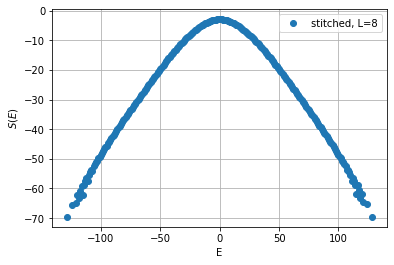

In [26]:
#plt.figure(figsize=(16, 9))

plt.plot([E for E in st["S"]],
         [S for E, S in st["S"].items()]
         , 'o', label="stitched, L={}".format(st["L"]))

plt.ylabel("$S(E)$")
plt.xlabel("E")

plt.legend()
plt.grid()
#plt.savefig("./S(E)_D{}_L{}.png".format(heat["D"], heat["L"]))

In [27]:
tmp = sorted([(x, st['S'][x]) for x in st['S']], key=lambda x: x[0])
tmp_bin = {}
for i in range(0, len(tmp) - 1):
    x = (((tmp[i + 1][0] - tmp[i][0]) + 0.025) // 0.05) * 0.05
    #tmp_bin.append(x)
    if x in tmp_bin:
        tmp_bin[x] += 1
    else:
        tmp_bin[x] = 1

In [28]:
tmp_bin

{4.0: 2, 3.0: 2, 1.0: 238, 2.0: 2}

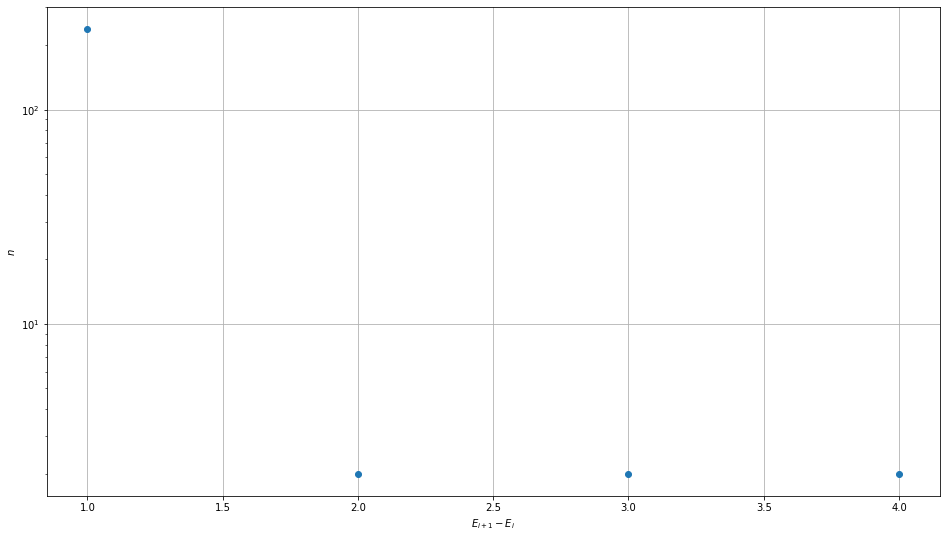

In [29]:
plt.figure(figsize=(16, 9))

plt.plot([x for x in tmp_bin], [tmp_bin[x] for x in tmp_bin], 'o')
#plt.hist(tmp_bin, bins=100)

plt.ylabel("$n$")
plt.yscale('log')
plt.xlabel("$E_{i+1} - E_i$")
plt.grid()
#plt.savefig("./bin_D{}_L{}.png".format(heat["D"], heat["L"]))

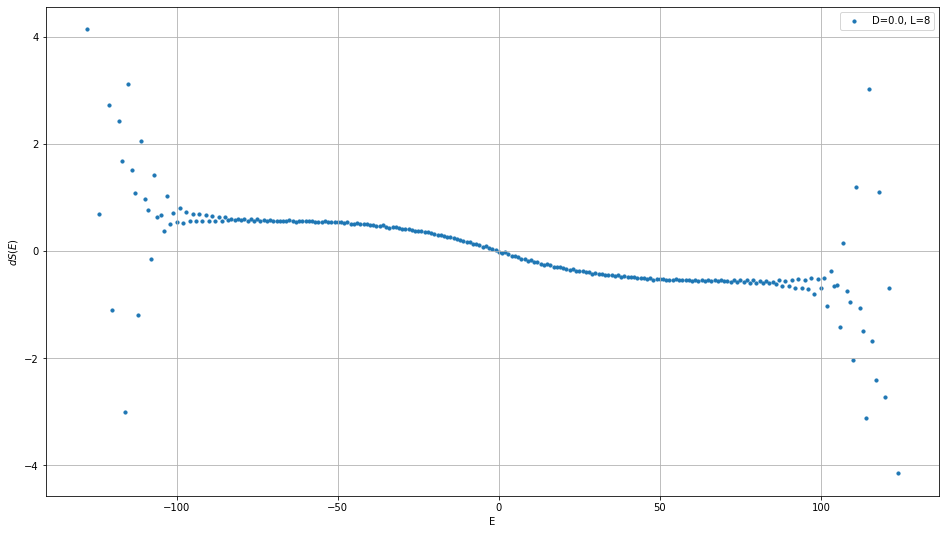

In [30]:
plt.figure(figsize=(16, 9))

plt.scatter([tmp[i][0] for i in range(0, len(tmp) - 1)],
         [tmp[i+1][1]-tmp[i][1] for i in range(0, len(tmp) - 1)],
         label="D={}, L={}".format(st["D"], st["L"]), s=10)

plt.ylabel("$dS(E)$")
plt.xlabel("E")

plt.legend()
plt.grid()
#plt.savefig("./dS(E)_D{}_L{}.png".format(heat["D"], heat["L"]))

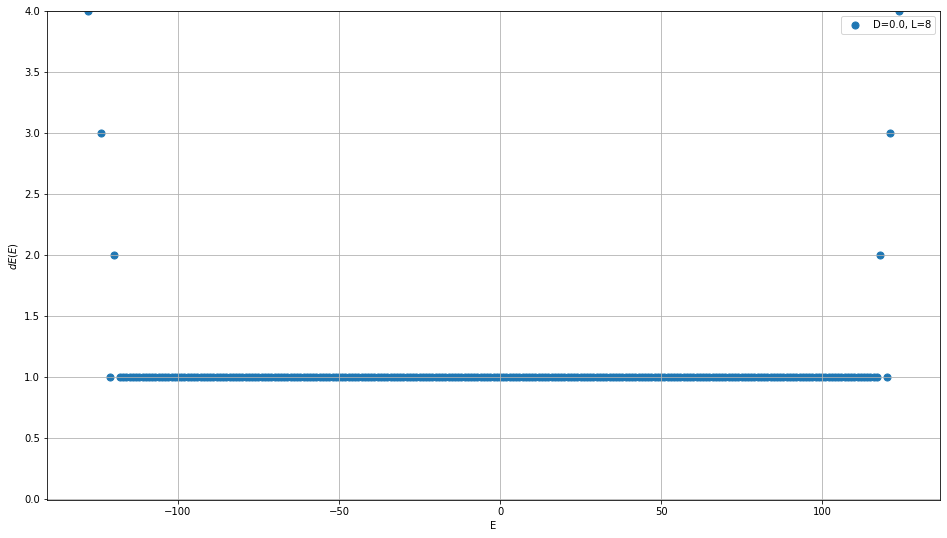

In [31]:
plt.figure(figsize=(16, 9))

plt.scatter([tmp[i][0] for i in range(0, len(tmp) - 1)],
            [tmp[i+1][0]-tmp[i][0] for i in range(0, len(tmp) - 1)]
            , label="D={}, L={}".format(st["D"], st["L"]), s=50)

plt.ylabel("$dE(E)$")
plt.xlabel("E")
#plt.yscale("log")
plt.ylim([-0.01, 4.0])

plt.legend()
plt.grid()
#plt.savefig("./dE(E)_D{}_L{}.png".format(heat["D"], heat["L"]))
#plt.savefig("./dE(E)_D{}_L{}_scale.png".format(heat["D"], heat["L"]))

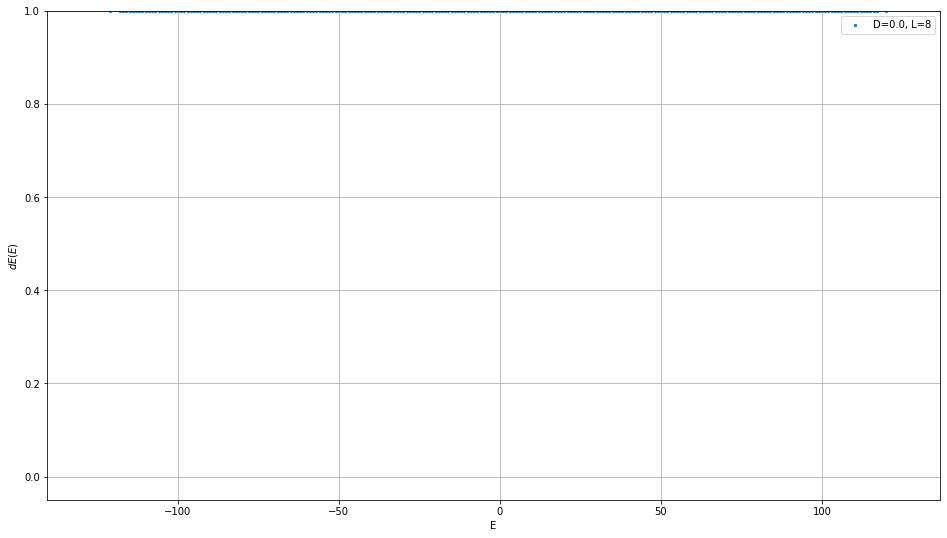

In [32]:
plt.figure(figsize=(16, 9))

plt.scatter([tmp[i][0] for i in range(0, len(tmp) - 1)],
            [tmp[i+1][0]-tmp[i][0] for i in range(0, len(tmp) - 1)]
            , label="D={}, L={}".format(st["D"], st["L"]), s=5)

plt.ylabel("$dE(E)$")
plt.xlabel("E")
plt.ylim([-0.05, 1])

plt.legend()
plt.grid()
#plt.savefig("./dE(E)_D{}_L{}_zoom.png".format(heat["D"], heat["L"]))

In [70]:
import mpmath as mp
mp.mp.dps = 50
mp.mp.pretty = True
print(mp.mp)

Mpmath settings:
  mp.prec = 169               [default: 53]
  mp.dps = 50                 [default: 15]
  mp.trap_complex = False     [default: False]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


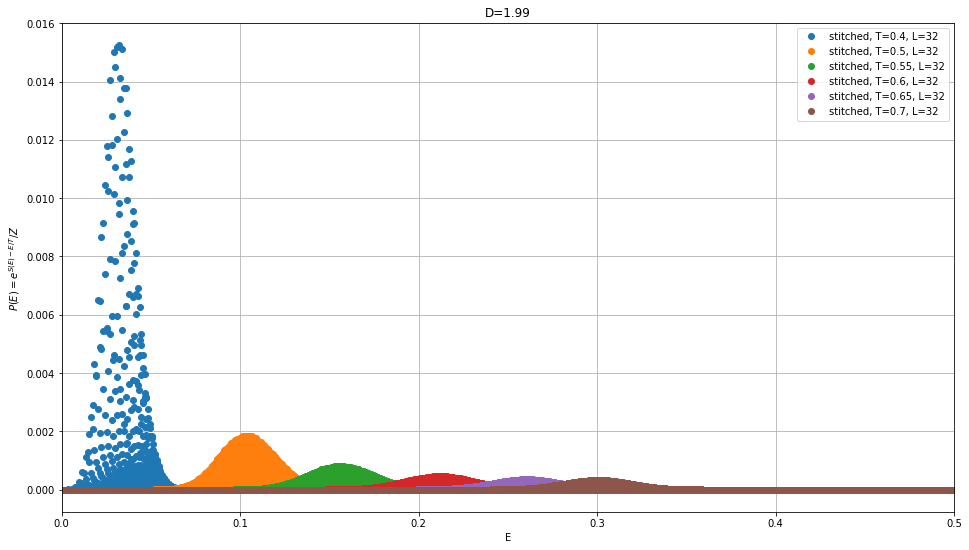

In [78]:
plt.figure(figsize=(16, 9))

for T in log_progress([0.4, 0.5, 0.55, 0.6, 0.65, 0.7]):
    for i, x in enumerate(parameters):
        heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
        D = st['D']
        L = st['L']
        if L != 32:
            continue
        lst = np.array([mp.exp(mp.mpf(S) - mp.mpf(E) / T) / Z for E, S in st["S"].items()])
        Z = sum(lst)
        plt.plot([E / (L * L) for E in st["S"]],
                 lst / Z
                 , 'o', label="stitched, T={}, L={}".format(T, L))

plt.ylabel('$P(E) = e^{S(E) - E / T} / Z$')
plt.xlabel("E")
plt.xlim([0, 0.5])
plt.title("D={}".format(D))
plt.legend()
plt.grid()
plt.savefig("./P(E)_D{}_L{}.png".format(heat["D"], heat["L"]))

In [120]:
def calc_hc(st, T):
    E = mp.mpf(0)
    E_sq = mp.mpf(0)
    Z = mp.mpf(0)
    for fe, fS in st['S'].items():
        e = mp.mpf(fe)
        S = mp.mpf(fS)
        w = mp.exp(S - e / T)
        Z += w
        E += w * e
        E_sq += w * e * e
    avgE = E / Z;
    avgE_sq = E_sq / Z;
    return (avgE_sq - avgE * avgE) / (T * T)

In [121]:
hc = {}

for i, x in enumerate(parameters):
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L
    hc[L] = {}
    for T in log_progress(np.linspace(0.4, 2.0, 20)):
        hc[L][T] = calc_hc(st, T)

Mpmath settings:
  mp.prec = 169               [default: 53]
  mp.dps = 50                 [default: 15]
  mp.trap_complex = False     [default: False]


In [122]:
a = 0.45
b = 0.65

In [123]:
for i, x in enumerate(parameters):
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L
    for T in log_progress(np.linspace(a, b, 20)):
        hc[L][T] = calc_hc(st, T)

In [124]:
T_crit = {}
for i, x in enumerate(parameters):
    st = x["stitched"]
    L = st["L"]
    t, c, _, _ = fminbound(lambda T: - calc_hc(st, T), a, b, maxfun=500, full_output=1, disp=2)
    T_crit[L] = {
        "T_crit": float(t),
        "C_crit": float(-c / (L * L))
    }
T_crit


Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


{8: {'T_crit': 0.5655595029490493, 'C_crit': 1.3117211299788991},
 16: {'T_crit': 0.5025298917010546, 'C_crit': 1.6433841094574113},
 24: {'T_crit': 0.5580220502044496, 'C_crit': 1.0973518665039232},
 32: {'T_crit': 0.5612410622219339, 'C_crit': 1.1090055122582425}}

In [125]:
with open("./T_crit_D{}.txt".format(heat["D"]), 'w') as fp:
    json.dump(T_crit, fp)


In [106]:
#D = heat["D"]
D = 1.99

In [107]:
with open("./T_crit_D{}.txt".format(D), 'r') as fp:
    T_crit = json.load(fp)
T_crit

{'8': {'T_crit': 0.5655594564636577, 'C_crit': 1.3117211299756153},
 '16': {'T_crit': 0.5025302326335092, 'C_crit': 1.6433841095738073},
 '24': {'T_crit': 0.5580232755558103, 'C_crit': 1.0973518665741406},
 '32': {'T_crit': 0.5612410399643981, 'C_crit': 1.109005512261693}}

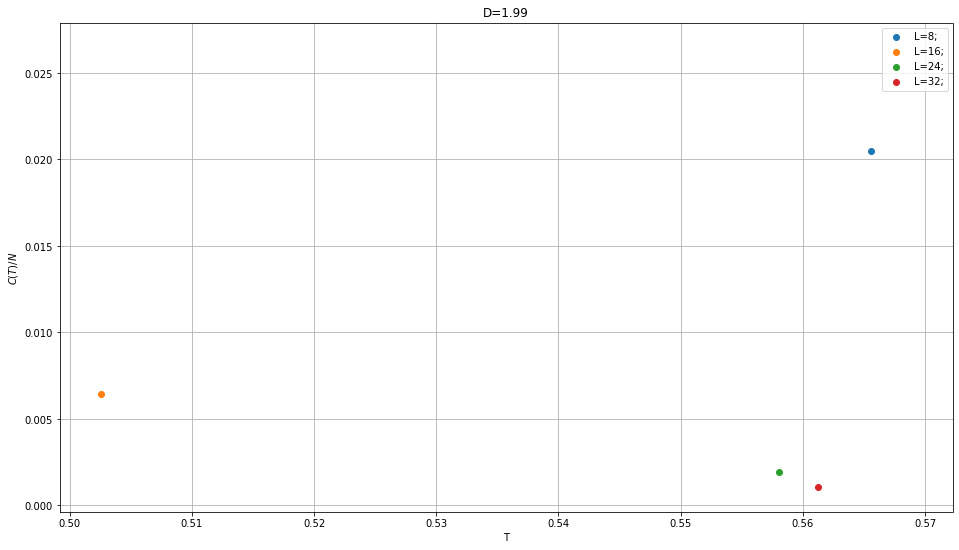

In [110]:
plt.figure(figsize=(16, 9))

for L in T_crit:
    plt.scatter(T_crit[L]['T_crit'], T_crit[L]['C_crit'] / (int(L) * int(L)), label='L={};'.format(L))

    
#plt.plot([Tc, Tc], [0, 3300], label='Tc_their={}'.format(Tc), c='r')
#for L, data in T_crit.items():
#    plt.plot([data['T_crit'], data['T_crit']], [0, 5], label='T_crit_our={:.4f}'.format(float(data['T_crit'])), c='r')

#plt.yscale("log")
plt.title("D={}".format(D))
plt.ylabel('$C(T) / N$')
plt.xlabel("T")
plt.legend()
plt.grid()
#plt.savefig("./C(T)_D{}_L{}.png".format(heat["D"], heat["L"]))
plt.savefig("./C(T)_D{}.png".format(D))

In [126]:
x = np.array([int(L) for L in T_crit.keys()])
y = np.array([T_crit[L]['T_crit'] for L in T_crit.keys()])
z = np.array([T_crit[L]['C_crit'] / (int(L) * int(L)) for L in T_crit.keys()])

slope: 	-1.9908811925959722 +/-
	0.5826120220843243
shift: 	0.6304638329860476 +/-
	0.027366074130993602


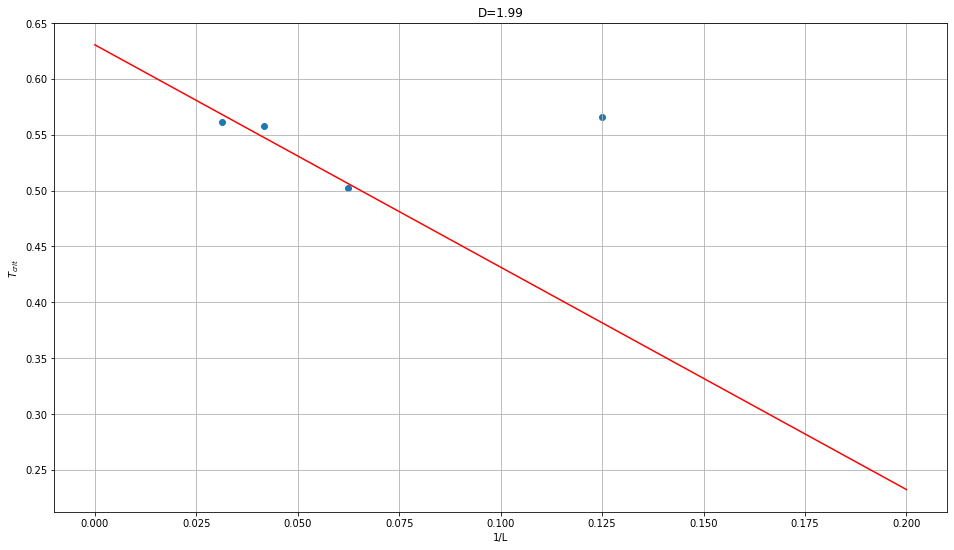

In [128]:
l = 1
fit = np.polyfit(1 / x[l:], list(map(float, y[l:])), 1, full=False)

plt.figure(figsize=(16, 9))

plt.scatter(1 / x, y)

sample = np.array([0, 0.2])
plt.plot(sample, fit[0] * sample + fit[1], 'r')

plt.title("D={}".format(D))
plt.ylabel('$T_{crit}$')
plt.xlabel("1/L")
#plt.yscale("log")
plt.grid()
plt.savefig("./finite_size_D{}.png".format(D))

p, V = np.polyfit(1 / x[l:], list(map(float, y[l:])), 1, cov=True)

print("slope: \t{} +/-\n\t{}".format(p[0], np.sqrt(V[0][0])))
print("shift: \t{} +/-\n\t{}".format(p[1], np.sqrt(V[1][1])))


In [27]:
#np.polyfit(x[1:], list(map(float, y[1:])), 1, full=True)

No handles with labels found to put in legend.


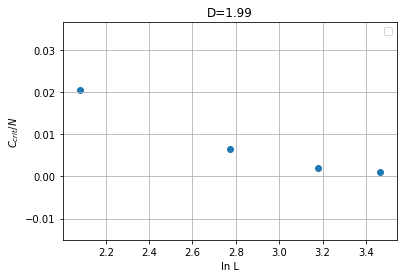

In [38]:
plt.scatter(np.log(x), z)

sample = np.array([0, 0.2])
#plt.plot(sample, fit[0] * sample + fit[1], 'r')

plt.title("D={}".format(cool["D"]))
plt.ylabel('$С_{crit} / N$')
plt.xlabel("ln L")
#plt.yscale("log")
plt.legend()
plt.grid()